In [1]:
import pandas as pd
from dataclasses import dataclass, asdict
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.utils.multiclass import type_of_target

import helpers
import consts
from dto import TaskRawData

helpers.period_days = 7

In [2]:
collumn_names = TaskRawData.collumn()

In [3]:
df = pd.DataFrame.from_records([asdict(task) for task in helpers.generate_dataset()])
df.to_csv("dataset1.csv")

In [4]:
df = df.drop(df[df.is_bind == False].index)
df = helpers.date_preprocessing(df)
df[['start_time', 'due_time']]
df.shape

(8990, 14)

In [5]:
df['other_task_on_start'] = helpers.other_task_on_start(df)
df['elapsed'] = helpers.calculate_target_with_noise(df)
# rel_elapsed = []
# for start, due, el in zip(df['start_time'], df['due_time'], df['elapsed']):
#     rel_elapsed.append(el/(due-start).total_seconds())
# df['elapsed'] = rel_elapsed



In [6]:
# кодируем категориальные признаки

for sign in consts.categorial_sign:
    tmp = pd.get_dummies(df[sign], prefix=sign)
    df = pd.concat([df,tmp], axis=1)


вроде более менее преобразованные данные получились,
необходимо убрать лишнее, это незакодированные категориальные признаки и возможно стоит убрать необработанное время
целевой признак затраченное время(elapsed)

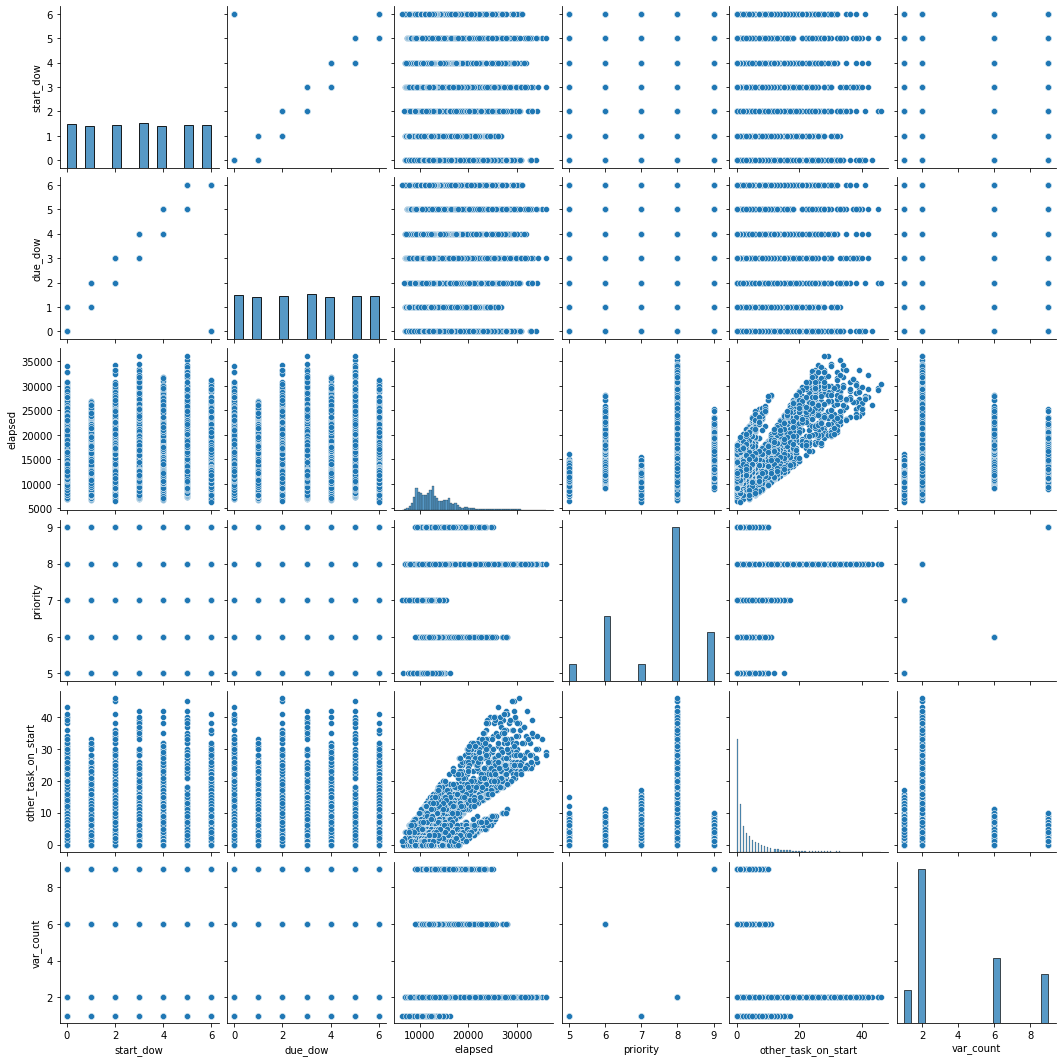

In [7]:

sns_plot = sns.pairplot(df[consts.pairplot_cols])

можно увидеть какие признаки точно влияют на целевой, а какие не очень

In [8]:
# "task_name_number", "assigner_number"
df = df.drop(columns=consts.need_drop)
df['is_bind'] = df['is_bind'].apply(lambda x: 1 if x else 0)


In [9]:
corr_matrix = df.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
sol[:30]

start_is_weekend           start_is_weekend_0                1.000000
due_is_weekend_0           due_is_weekend_1                  1.000000
due_is_weekend             due_is_weekend_0                  1.000000
start_is_weekend_0         start_is_weekend_1                1.000000
start_is_weekend           start_is_weekend_1                1.000000
process_name_Разработка    task_name_Сделай гугл             1.000000
process_name_Заказ товара  task_name_проверка склада         1.000000
due_is_weekend             due_is_weekend_1                  1.000000
process_name_закупка       task_name_Оформить заявку         1.000000
start_dow                  due_dow                           0.990885
start_is_weekend_0         due_is_weekend_0                  0.990729
start_is_weekend_1         due_is_weekend_0                  0.990729
start_is_weekend           due_is_weekend_0                  0.990729
start_is_weekend_0         due_is_weekend_1                  0.990729
due_is_weekend      

т.к. корреляция признаков сильная, попробуем использовать Ridge  и Lasso регрессии

In [10]:

Y = df.elapsed.values
X = df.drop(columns=['elapsed'])
df.shape


(8990, 34)

In [11]:
# X.head()
# X

In [12]:

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, ShuffleSplit

from models import scaler, ridge, lasso, skf, cv

print(ridge, lasso)


scaler.fit(X) 
# save scaler

X_scaled = scaler.transform(X)



RidgeCV(alphas=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])) LassoCV(max_iter=10000, random_state=42)


In [13]:
# check r2 score for comparison models
ridge_cvs = cross_val_score(ridge, X_scaled, Y, cv=cv)
lasso_cvs = cross_val_score(lasso, X_scaled, Y, cv=cv)
print(ridge_cvs)
print(lasso_cvs)
print(ridge_cvs.mean(), lasso_cvs.mean())

[0.86238818 0.8678992  0.8608425 ]
[0.86218071 0.86766202 0.86057447]
0.8637099567382812 0.8634724005927406


 Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 50 % (в этом случае коэффициент множественной корреляции превышает по модулю 70 %). Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими (коэффициент корреляции превышает 90 %). Значение коэффициента детерминации 1 означает функциональную зависимость между переменными.
 
У нас на синтетических данных явно прослеживается зависимость от количвества других задач на время начала задачи и приоритета задачи, поэтому коэфициент детерминации высокий

In [14]:

split_indexes = skf.split(X_scaled, Y)
ridge = helpers.fit_model(ridge, X_scaled, Y, split_indexes)

split_indexes = skf.split(X_scaled, Y)
lasso = helpers.fit_model(lasso, X_scaled, Y, split_indexes)



######


/home/roman/projects/jupiter/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


RidgeCV(alphas=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])):
score: [0.857798759216799, 0.8688531809369009]
mse: [2498231.246260266, 2341305.235696767]
mae [1072.1876856500533, 1050.7657103765437]
me [9634.443030769275, 9680.582020253969]
mape [0.07819301770460729, 0.07852823890576673]
######


/home/roman/projects/jupiter/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


LassoCV(max_iter=10000, random_state=42):
score: [0.8558434042079075, 0.8659957141531809]
mse: [2532583.470993606, 2392318.306309897]
mae [1090.3376590405287, 1060.5327684834149]
me [10066.83059134664, 10050.3196967427]
mape [0.07986291477977099, 0.07917272674277993]


In [15]:
ridge.feature_names = list(X.columns.values)
lasso.feature_names = list(X.columns.values)

## SAVE models

In [17]:
from joblib import dump
dump(ridge, 'ridge.joblib') 
dump(lasso, 'lasso.joblib')

dump(scaler, 'scaler.joblib')
# model = joblib.load("lasso.joblib")


['scaler.joblib']

In [18]:
# from joblib import load
# import numpy as np
# model = load("lasso.joblib")
# model.predict(np.array([ 0.        , -1.16247639,  1.54901047,  1.54901047, -0.53935003,
#         1.73205081, -0.57735027, -0.57735027, -0.57735027, -0.57735027,
#        -0.57735027, -0.57735027,  1.73205081,  0.        , -0.69916647,
#        -0.68468113,  1.35531525, -0.41733475, -0.44989422, -0.37652323,
#        -0.42692623, -0.35305601,  2.29128785, -0.39364538, -0.41733475,
#        -0.44989422, -0.37652323, -0.42692623, -0.35305601,  2.29128785,
#        -0.39364538]).reshape(1,-1))

## predict example
берем задачу и преобразуем под вид, который принимает модель

In [40]:

task_example = TaskRawData(
    process_name="Поддержка",
    task_name="Фикс чего-то там",
    owner="Василек",
    assigner="Соня",
    start_time=datetime(2021, 8, 31, 17, 51, 58),
    end_time=None,
    due_time=datetime(2021, 8, 31, 18, 51, 58),
    priority=4,
    var_count=1,
    is_bind=True
)
# TaskRawData(process_name='Заказ товара', task_name='проверка склада', owner='BOSS', assigner='Глеб', start_time=datetime.datetime(2021, 8, 31, 17, 51, 58), end_time=datetime.datetime(2021, 8, 31, 18, 51, 18, 302065), due_time=datetime.datetime(2021, 8, 31, 18, 51, 58), priority=50, var_count=1)

In [41]:
from joblib import load

model = load("ridge.joblib")
scaler = load("scaler.joblib")

assigner = "Глеб"
task_example.assigner = assigner

active_task_count = 2
processing_val = helpers.processing_val([task_example], active_task_count, model, scaler)
predict = model.predict(processing_val)
print(predict)

[10625.1580713]
